In [ ]:
!pip install -q pyspark==3.1.2 spark-nlp==4.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.4/448.4 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 13.9 MB/s eta 0:00:00


In [ ]:
import sparknlp
import pandas as pd
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import array_contains
from sparknlp.annotator import *
from sparknlp.common import RegexRule
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import HashingTF, Tokenizer
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline # pipeline to transform data
from pyspark.sql import SparkSession # to initiate spark
from pyspark.sql.types import FloatType
from pyspark.ml.feature import RegexTokenizer # tokenizer
from pyspark.ml.feature import HashingTF, IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.sql.functions import concat_ws, col # to concatinate cols
from pyspark.ml.classification import LogisticRegression # ml model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # to evaluate the model

from pyspark.mllib.evaluation import MulticlassMetrics #  performance metrics
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType
from pyspark.sql.types import IntegerType


spark = sparknlp.start()
print("Spark NLP Version:", sparknlp.version())
print("Apache Spark version:", spark.version)


spark

Spark NLP Version: 4.2.4
Apache Spark version: 3.1.2


In [ ]:
spark = SparkSession.builder.master("local[*]")\
                            .appName("news classfier")\
                            .getOrCreate()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yelp_review_train.csv to yelp_review_train.csv


In [ ]:
from google.colab import files
uploaded2 = files.upload()


Saving yelp_review_test.csv to yelp_review_test.csv


In [ ]:
yelp_review_train = uploaded

In [ ]:
yelp_review_test = uploaded2

In [ ]:
columns = ["label", "text"]

In [ ]:
yelp_review_train = spark.read \
   .option("header", True) \
   .csv("yelp_review_train.csv")

yelp_review_train.show(10, truncate=150)

+------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------+
|   _c0|label|                                                                                                                                                  text|
+------+-----+------------------------------------------------------------------------------------------------------------------------------------------------------+
|203363|    4|"Great BBQ dinners.  I have had the chicken and beef and both are excellent.  I especially like the ""Thank Q\"" donut at the end of dinner.  Very ...|
|292846|    1|FOLLOW UP :  The Guest Service Management contacted me and they have been very kind, helpful and friendly.  They have offered us another try.  We w...|
|152793|    0|Nothing positive to say about this place. Absolutely awful. We ordered three plates at lunch. Shredded beef tacos: no beef, no taste of what beef t...|
|553

In [ ]:
yelp_review_test = spark.read \
   .option("header", True) \
   .csv("yelp_review_test.csv")

yelp_review_test.show(10, truncate=150)

+-----+-----+------------------------------------------------------------------------------------------------------------------------------------------------------+
|  _c0|label|                                                                                                                                                  text|
+-----+-----+------------------------------------------------------------------------------------------------------------------------------------------------------+
| 8226|    4|                 The people that work here are amazing. All of them. They're not only friendly but they take care things. Great experience every time.|
|36026|    2|                                                                                             The boba drink was terrible, but the shaved ice was good.|
|48918|    2|My expectations may be too high...let's start off with the positives.  Big parking lot, modern decor and very spacious.  Great service for having o...|
|35478|   

In [ ]:
yelp_review_train.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- label: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
yelp_review_test.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- label: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
yelp_review_train = yelp_review_train.dropna()

In [ ]:
yelp_review_test = yelp_review_test.dropna()

In [ ]:
yelp_review_train.count()

32500

In [ ]:
yelp_review_test.count()

5000

In [ ]:
yelp_review_train= yelp_review_train.withColumnRenamed('_c0', 'id')

In [ ]:
yelp_review_test= yelp_review_test.withColumnRenamed('_c0', 'id')

In [ ]:
# convert sentences to list of words
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# adds a column 'words' to df after tokenization
yelp_review_train = tokenizer.transform(yelp_review_train)

yelp_review_train.select(['label','text', 'words']).show(5)

+-----+--------------------+--------------------+
|label|                text|               words|
+-----+--------------------+--------------------+
|    4|"Great BBQ dinner...|[great, bbq, dinn...|
|    1|FOLLOW UP :  The ...|[follow, up, the,...|
|    0|Nothing positive ...|[nothing, positiv...|
|    2|Ship-wrecked burg...|[ship, wrecked, b...|
|    1|Ok, I changed my ...|[ok, i, changed, ...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# convert sentences to list of words
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# adds a column 'words' to df after tokenization
yelp_review_test = tokenizer.transform(yelp_review_test)

yelp_review_test.select(['label','text', 'words']).show(5)

+-----+--------------------+--------------------+
|label|                text|               words|
+-----+--------------------+--------------------+
|    4|The people that w...|[the, people, tha...|
|    2|The boba drink wa...|[the, boba, drink...|
|    2|My expectations m...|[my, expectations...|
|    4|Very clean and co...|[very, clean, and...|
|    4|One of my new fav...|[one, of, my, new...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# to remove stop words like is, the, in, etc.
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# adds a column 'filtered' to df without stopwords
yelp_review_train = stopwords_remover.transform(yelp_review_train)

yelp_review_train.select(['label','text', 'words', 'filtered']).show(5)


+-----+--------------------+--------------------+--------------------+
|label|                text|               words|            filtered|
+-----+--------------------+--------------------+--------------------+
|    4|"Great BBQ dinner...|[great, bbq, dinn...|[great, bbq, dinn...|
|    1|FOLLOW UP :  The ...|[follow, up, the,...|[follow, guest, s...|
|    0|Nothing positive ...|[nothing, positiv...|[nothing, positiv...|
|    2|Ship-wrecked burg...|[ship, wrecked, b...|[ship, wrecked, b...|
|    1|Ok, I changed my ...|[ok, i, changed, ...|[ok, changed, min...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# to remove stop words like is, the, in, etc.
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# adds a column 'filtered' to df without stopwords
yelp_review_test = stopwords_remover.transform(yelp_review_test)

yelp_review_test.select(['label','text', 'words', 'filtered']).show(5)


+-----+--------------------+--------------------+--------------------+
|label|                text|               words|            filtered|
+-----+--------------------+--------------------+--------------------+
|    4|The people that w...|[the, people, tha...|[people, work, am...|
|    2|The boba drink wa...|[the, boba, drink...|[boba, drink, ter...|
|    2|My expectations m...|[my, expectations...|[expectations, ma...|
|    4|Very clean and co...|[very, clean, and...|[clean, comfortab...|
|    4|One of my new fav...|[one, of, my, new...|[one, new, favori...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Calculate term frequency in each article
hashing_tf = HashingTF(inputCol="filtered",
                       outputCol="raw_features",
                       numFeatures=10000)

# adds raw tf features to df
featurized_data = hashing_tf.transform(yelp_review_train)

In [ ]:
# Calculate term frequency in each article
hashing_tf2 = HashingTF(inputCol="filtered",
                       outputCol="raw_features",
                       numFeatures=10000)

# adds raw tf features to df
featurized_data2 = hashing_tf2.transform(yelp_review_test)

In [ ]:
# Inverse document frequency
idf = IDF(inputCol="raw_features", outputCol="features")

idf_vectorizer = idf.fit(featurized_data)

# converting text to vectors
rescaled_data = idf_vectorizer.transform(featurized_data)

# top 20 rows
rescaled_data.select("label",'text', 'words', 'filtered', "features").show()

+-----+--------------------+--------------------+--------------------+--------------------+
|label|                text|               words|            filtered|            features|
+-----+--------------------+--------------------+--------------------+--------------------+
|    4|"Great BBQ dinner...|[great, bbq, dinn...|[great, bbq, dinn...|(10000,[264,309,3...|
|    1|FOLLOW UP :  The ...|[follow, up, the,...|[follow, guest, s...|(10000,[20,39,86,...|
|    0|Nothing positive ...|[nothing, positiv...|[nothing, positiv...|(10000,[1,47,129,...|
|    2|Ship-wrecked burg...|[ship, wrecked, b...|[ship, wrecked, b...|(10000,[750,2252,...|
|    1|Ok, I changed my ...|[ok, i, changed, ...|[ok, changed, min...|(10000,[298,340,4...|
|    3|lovely to look at...|[lovely, to, look...|[lovely, look, ac...|(10000,[47,524,62...|
|    0|Want to pay a lot...|[want, to, pay, a...|[want, pay, lot, ...|(10000,[313,350,3...|
|    0|"Every time I wal...|[every, time, i, ...|[every, time, wal...|(10000,[80

In [ ]:
# Inverse document frequency
idf2 = IDF(inputCol="raw_features", outputCol="features")

idf_vectorizer2 = idf.fit(featurized_data2)

# converting text to vectors
rescaled_data2 = idf_vectorizer.transform(featurized_data2)

# top 20 rows
rescaled_data2.select("label",'text', 'words', 'filtered', "features").show()

+-----+--------------------+--------------------+--------------------+--------------------+
|label|                text|               words|            filtered|            features|
+-----+--------------------+--------------------+--------------------+--------------------+
|    4|The people that w...|[the, people, tha...|[people, work, am...|(10000,[44,750,85...|
|    2|The boba drink wa...|[the, boba, drink...|[boba, drink, ter...|(10000,[3434,3932...|
|    2|My expectations m...|[my, expectations...|[expectations, ma...|(10000,[18,52,264...|
|    4|Very clean and co...|[very, clean, and...|[clean, comfortab...|(10000,[494,763,1...|
|    4|One of my new fav...|[one, of, my, new...|[one, new, favori...|(10000,[141,157,2...|
|    2|This review is fo...|[this, review, is...|[review, weekend,...|(10000,[141,316,4...|
|    4|Amazing happy hou...|[amazing, happy, ...|[amazing, happy, ...|(10000,[44,527,50...|
|    0|Very expensive to...|[very, expensive,...|[expensive, touri...|(10000,[13

In [ ]:
# Split Train/Test data
(train, test) = rescaled_data.randomSplit([0.75, 0.25], seed = 202)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))



Training Dataset Count: 24341
Test Dataset Count: 8159


In [ ]:
# Split Train/Test data
(train2, test2) = rescaled_data2.randomSplit([0.75, 0.25], seed = 202)
print("Training Dataset Count: " + str(train2.count()))
print("Test Dataset Count: " + str(test2.count()))



Training Dataset Count: 3749
Test Dataset Count: 1251


In [ ]:

df_train = rescaled_data.withColumn("label",col("label").cast(IntegerType()))
df_test = rescaled_data.withColumn("label",col("label").cast(IntegerType()))
df_train2 = rescaled_data2.withColumn("label",col("label").cast(IntegerType()))
df_test2 = rescaled_data2.withColumn("label",col("label").cast(IntegerType()))

df_train.printSchema()
df_train2.printSchema()
df_test.printSchema()
df_test2.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string 

In [ ]:
# model object
lr = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel = lr.fit(df_train)

# get predictions for test set
predictions = lrModel.transform(df_test)

# show top 20 predictions
predictions.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|"Great BBQ dinner...|[0.09643563504794...|       4.0|    4|
|FOLLOW UP :  The ...|[0.18797877168501...|       1.0|    1|
|Nothing positive ...|[0.66438092836703...|       0.0|    0|
|Ship-wrecked burg...|[0.24693579857036...|       2.0|    2|
|Ok, I changed my ...|[0.11064982230780...|       1.0|    1|
|lovely to look at...|[0.17183269314135...|       2.0|    3|
|Want to pay a lot...|[0.26037093786738...|       0.0|    0|
|"Every time I wal...|[0.75771788317918...|       0.0|    0|
|I've eaten at a l...|[0.07282811955363...|       4.0|    4|
|Not impressed. To...|[0.24614103934600...|       1.0|    1|
|Food and service ...|[0.13260302771194...|       4.0|    3|
|I love this prome...|[0.08443308448397...|       3.0|    3|
|Terrible service....|[0.43754837244983...|       0.0|    0|
|My go-to hotel in...|[0

In [ ]:
# model object
lr2 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel2 = lr2.fit(df_train2)

# get predictions for test set
predictions2 = lrModel2.transform(df_test2)

# show top 20 predictions
predictions2.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|The people that w...|[0.14750830007125...|       4.0|    4|
|The boba drink wa...|[0.20798139083838...|       4.0|    2|
|My expectations m...|[0.02096261230174...|       2.0|    2|
|Very clean and co...|[0.06018103162377...|       4.0|    4|
|One of my new fav...|[0.01349105679400...|       4.0|    4|
|This review is fo...|[0.00559528913876...|       2.0|    2|
|Amazing happy hou...|[0.15291499777058...|       4.0|    4|
|Very expensive to...|[0.23766767545945...|       1.0|    0|
|"Rolled up late a...|[0.14461681133672...|       2.0|    2|
|A/c broken tonigh...|[0.15802384681572...|       1.0|    1|
|i was only outsid...|[0.09587546373416...|       2.0|    3|
|Pros: Friendly st...|[0.03229002467529...|       4.0|    4|
|We loved this pla...|[0.16953834461353...|       4.0|    1|
|"HORRIBLE HORRIBL...|[0

In [ ]:
# to evalute model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))



Test-set Accuracy is :  0.7394356643992198


In [ ]:
# to evalute model
evaluator2 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator.evaluate(predictions2))


Test-set Accuracy is :  0.9567827084278211


In [ ]:
#Pipeline Approach
# Select new text feature and labels
yelp_review_train = yelp_review_train.select('label', 'text')
yelp_review_test = yelp_review_test.select('label', 'text')

# tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# term frequency
hashing_tf = HashingTF(inputCol="filtered",
                       outputCol="raw_features",
                       numFeatures=10000)

# Inverse Document Frequency - vectorizer
idf = IDF(inputCol="raw_features", outputCol="features")

df_train3 = yelp_review_train.withColumn("label",col("label").cast(IntegerType()))
df_test3 = yelp_review_test.withColumn("label",col("label").cast(IntegerType()))
df_train3.printSchema()
df_test3.printSchema()


root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)

root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
# model
lr3 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# model
lr4 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

In [ ]:

# Put everything in pipeline
pipeline = Pipeline(stages=[tokenizer,
                            stopwords_remover,
                            hashing_tf,
                            idf,
                            lr])

# Fit the pipeline to training documents
pipelineFit = pipeline.fit(df_train3)

# transform add train
train_dataset = pipelineFit.transform(df_train3)

# show top 10 predictions
train_dataset.show(10)


# Put everything in pipeline
pipeline2 = Pipeline(stages=[tokenizer,
                            stopwords_remover,
                            hashing_tf,
                            idf,
                            lr])

# Fit the pipeline to training documents.
pipelineFit2 = pipeline2.fit(df_test3)

# transform add train
test_dataset = pipelineFit2.transform(df_test3)

# show top 10 predictions
test_dataset.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|label|                text|               words|            filtered|        raw_features|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    4|"Great BBQ dinner...|[great, bbq, dinn...|[great, bbq, dinn...|(10000,[264,309,3...|(10000,[264,309,3...|[-0.5784785605926...|[0.09643563504794...|       4.0|
|    1|FOLLOW UP :  The ...|[follow, up, the,...|[follow, guest, s...|(10000,[20,39,86,...|(10000,[20,39,86,...|[1.92233080491253...|[0.18797877168501...|       1.0|
|    0|Nothing positive ...|[nothing, positiv...|[nothing, positiv...|(10000,[1,47,129,...|(10000,[1,47,129,...|[2.08542813202120...|[0.66438092836703...|       0.0|
|   

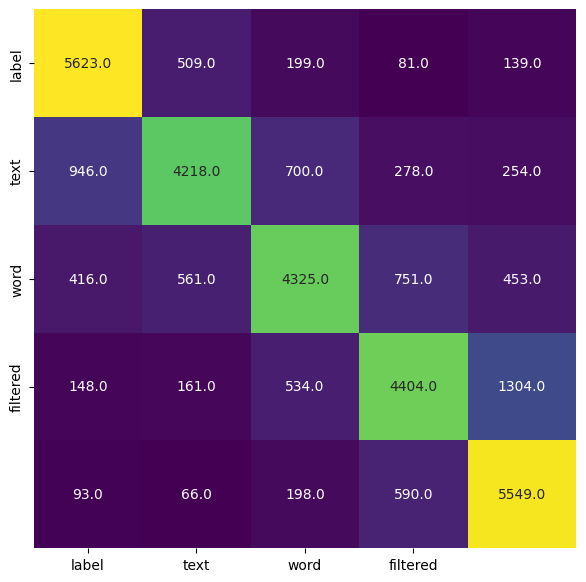

In [ ]:
labels = ["label", "text", "word", "filtered"]

# important: need to cast to float type, and order by prediction, else it won't work
preds_and_labels = predictions.select(['prediction','label']) \
                              .withColumn('label', col('label') \
                              .cast(FloatType())) \
                              .orderBy('prediction')
# generate metrics
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# figure object
_ = plt.figure(figsize=(7, 7))

# plot confusion matrix
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.show()

In [ ]:
# Split Train/Test data 30K
(train5, test5) = rescaled_data.randomSplit([0.93, 0.07], seed= 2000)
print("Training Dataset Count: " + str(train5.count()))
print("Test Dataset Count: " + str(test5.count()))

Training Dataset Count: 30242
Test Dataset Count: 2258


In [ ]:

df_train5 = train5.withColumn("label",col("label").cast(IntegerType()))
df_test5 = test5.withColumn("label",col("label").cast(IntegerType()))


df_train5.printSchema()
df_test5.printSchema()


root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# model object
lr5 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel5 = lr5.fit(df_train5)

# get predictions for test set
predictions5 = lrModel5.transform(df_test5)

# show top 20 predictions
predictions5.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|Went for lunch. I...|[0.28370399576255...|       0.0|    0|
|Indeed one of the...|[0.12218237297509...|       4.0|    3|
|This was the wors...|[0.63659483451377...|       0.0|    1|
|"This McDonald's ...|[0.28540315068069...|       0.0|    0|
|$8 for a tiny san...|[0.24565785509163...|       1.0|    0|
|Long Wongs is a g...|[0.08766939593100...|       2.0|    2|
|Ventured to Los O...|[0.04031256232374...|       2.0|    2|
|Okay, so I have a...|[0.02149752569682...|       4.0|    4|
|I read some great...|[0.15516346748264...|       4.0|    3|
|The people in the...|[0.23091597246174...|       3.0|    3|
|I dont mind drift...|[0.00701051936351...|       2.0|    2|
|Different kind of...|[0.07713956023174...|       2.0|    4|
|"So, this place i...|[0.04876853138716...|       2.0|    1|
|I've stopped in t...|[0

In [ ]:
# to evalute model
evaluator5 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator5.evaluate(predictions5))

Test-set Accuracy is :  0.4937826506964701


In [ ]:
# Split Train/Test data 25K
(train6, test6) = rescaled_data.randomSplit([0.77, 0.23], seed= 2000)
print("Training Dataset Count: " + str(train6.count()))
print("Test Dataset Count: " + str(test6.count()))

Training Dataset Count: 25137
Test Dataset Count: 7363


In [ ]:
df_train6 = train6.withColumn("label",col("label").cast(IntegerType()))
df_test6 = test6.withColumn("label",col("label").cast(IntegerType()))


df_train6.printSchema()
df_test6.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# model object
lr6 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel6 = lr6.fit(df_train6)

# get predictions for test set
predictions6 = lrModel6.transform(df_test6)

# show top 20 predictions
predictions6.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|didn't they close...|[0.39213368710039...|       0.0|    0|
|Went for lunch. I...|[0.28020707328567...|       0.0|    0|
|"My family and I ...|[0.17214507260511...|       1.0|    2|
|Boyfriend & I wer...|[0.50427773923365...|       0.0|    0|
|The Orange Table ...|[0.04158637751851...|       3.0|    4|
|Indeed one of the...|[0.12994437580252...|       4.0|    3|
|Okay, sorry guys....|[0.24173092024796...|       1.0|    1|
|I used to love th...|[0.20905446359490...|       1.0|    2|
|This was the wors...|[0.63039431896144...|       0.0|    1|
|Six always ends m...|[0.05137298214854...|       2.0|    4|
|This place is cra...|[0.04938023443347...|       4.0|    3|
|"The staff was be...|[0.24983239899728...|       1.0|    0|
|"This McDonald's ...|[0.28515941588851...|       0.0|    0|
|$8 for a tiny san...|[0

In [ ]:
# to evalute model
evaluator6 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator6.evaluate(predictions6))

Test-set Accuracy is :  0.49089448741318975


In [ ]:
# Split Train/Test data 20K
(train7, test7) = rescaled_data.randomSplit([0.62, 0.38], seed= 2000)
print("Training Dataset Count: " + str(train7.count()))
print("Test Dataset Count: " + str(test7.count()))

Training Dataset Count: 20271
Test Dataset Count: 12229


In [ ]:
df_train7 = train7.withColumn("label",col("label").cast(IntegerType()))
df_test7 = test7.withColumn("label",col("label").cast(IntegerType()))


df_train7.printSchema()
df_test7.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# model object
lr7 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel7 = lr7.fit(df_train7)

# get predictions for test set
predictions7 = lrModel7.transform(df_test7)

# show top 20 predictions
predictions7.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|Yuck. Wife and I ...|[0.09769634153495...|       1.0|    0|
|I believe this sm...|[0.08314361831474...|       1.0|    2|
|They stopped havi...|[0.20038303958509...|       2.0|    2|
|didn't they close...|[0.39312074737731...|       0.0|    0|
|Went for lunch. I...|[0.28048443645106...|       0.0|    0|
|"My family and I ...|[0.15327976325785...|       1.0|    2|
|Boyfriend & I wer...|[0.53517501331312...|       0.0|    0|
|"I am a spring tr...|[0.00797908130629...|       3.0|    4|
|One of my absolut...|[0.26976474905379...|       3.0|    4|
|Zimbrick Acura is...|[0.46747991062350...|       0.0|    0|
|The Orange Table ...|[0.03468206656767...|       3.0|    4|
|Not a huge fan.  ...|[0.24732827658878...|       1.0|    1|
|Indeed one of the...|[0.13220362737497...|       3.0|    3|
|Okay, sorry guys....|[0

In [ ]:
# to evalute model
evaluator7 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator7.evaluate(predictions7))

Test-set Accuracy is :  0.4746831612280654


In [ ]:
# Split Train/Test data 15K
(train8, test8) = rescaled_data.randomSplit([0.46,0.54], seed= 2000)
print("Training Dataset Count: " + str(train8.count()))
print("Test Dataset Count: " + str(test8.count()))

Training Dataset Count: 15070
Test Dataset Count: 17430


In [ ]:
df_train8 = train8.withColumn("label",col("label").cast(IntegerType()))
df_test8 = test8.withColumn("label",col("label").cast(IntegerType()))


df_train8.printSchema()
df_test8.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# model object
lr8 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel8 = lr8.fit(df_train8)

# get predictions for test set
predictions8 = lrModel8.transform(df_test8)

# show top 20 predictions
predictions8.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|Yuck. Wife and I ...|[0.03533302121567...|       1.0|    0|
|I believe this sm...|[0.07569922235273...|       1.0|    2|
|On 11-19-10 @ 1:4...|[0.69385185717297...|       0.0|    0|
|They stopped havi...|[0.19563513567746...|       2.0|    2|
|Same as the other...|[0.23252390003474...|       1.0|    0|
|didn't they close...|[0.36612714900686...|       0.0|    0|
|Went for lunch. I...|[0.28645996758369...|       0.0|    0|
|I'm not a huge fa...|[0.09375501974801...|       4.0|    3|
|"My family and I ...|[0.21522025294045...|       1.0|    2|
|Just an update to...|[0.19587448873527...|       3.0|    2|
|Delicious non-fra...|[0.02937278921683...|       2.0|    3|
|Boyfriend & I wer...|[0.56652968842539...|       0.0|    0|
|"I am a spring tr...|[0.01043522227439...|       3.0|    4|
|One of my absolut...|[0

In [ ]:
# to evalute model
evaluator8 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator8.evaluate(predictions8))

Test-set Accuracy is :  0.4646821818497344


In [ ]:
# Split Train/Test data 10K
(train9, test9) = rescaled_data.randomSplit([0.32,0.68], seed= 2000)
print("Training Dataset Count: " + str(train9.count()))
print("Test Dataset Count: " + str(test9.count()))

Training Dataset Count: 10323
Test Dataset Count: 22177


In [ ]:
df_train9 = train9.withColumn("label",col("label").cast(IntegerType()))
df_test9 = test9.withColumn("label",col("label").cast(IntegerType()))


df_train9.printSchema()
df_test9.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
# model object
lr9 = LogisticRegression(featuresCol='features',
                        labelCol='label',
                        family="multinomial",
                        regParam=0.3,
                        elasticNetParam=0,
                        maxIter=50)

# train model with default parameters
lrModel9 = lr9.fit(df_train9)

# get predictions for test set
predictions9 = lrModel9.transform(df_test9)

# show top 20 predictions
predictions9.select("text", 'probability','prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|                text|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|Very clean. The p...|[0.40330263472442...|       1.0|    2|
|I have been eatin...|[0.25366858760379...|       0.0|    3|
|Yuck. Wife and I ...|[0.24320223230277...|       1.0|    0|
|I believe this sm...|[0.06640149597730...|       3.0|    2|
|On 11-19-10 @ 1:4...|[0.56228477130751...|       0.0|    0|
|"They originally ...|[0.97531205628301...|       0.0|    0|
|They stopped havi...|[0.19257040396191...|       2.0|    2|
|Same as the other...|[0.26620514650272...|       1.0|    0|
|didn't they close...|[0.32664798882946...|       0.0|    0|
|Went for lunch. I...|[0.27702252594908...|       0.0|    0|
|I'm not a huge fa...|[0.08652410971907...|       4.0|    3|
|"My family and I ...|[0.29123195562113...|       1.0|    2|
|Just an update to...|[0.20222464535228...|       3.0|    2|
|Delicious non-fra...|[0

In [ ]:
# to evalute model
evaluator9 = MulticlassClassificationEvaluator(predictionCol="prediction")

# print test accuracy
print("Test-set Accuracy is : ", evaluator9.evaluate(predictions9))

Test-set Accuracy is :  0.45231865863757914


In [ ]:
# Accuracy decreased as the training set sample size decreased
# higher test set used than the training set
# Sampling the data using 30K, 25K, 20K, 15K, and 10K produced biased results
#none of the random sample models are good models - accuracy is too low and errors are high

In [ ]:
# Split Train/Test data
(train10, test10) = rescaled_data.randomSplit([0.75, 0.25], seed = 202)
print("Training Dataset Count: " + str(train10.count()))
print("Test Dataset Count: " + str(test10.count()))


Training Dataset Count: 24341
Test Dataset Count: 8159


In [ ]:
# Split Train/Test data
(train11, test11) = rescaled_data2.randomSplit([0.75, 0.25], seed = 202)
print("Training Dataset Count: " + str(train11.count()))
print("Test Dataset Count: " + str(test11.count()))

Training Dataset Count: 3749
Test Dataset Count: 1251


In [ ]:
df_train10 = train10.withColumn("label",col("label").cast(IntegerType()))
df_test10 = test10.withColumn("label",col("label").cast(IntegerType()))
df_train11 = train11.withColumn("label",col("label").cast(IntegerType()))
df_test11 = test11.withColumn("label",col("label").cast(IntegerType()))

df_train10.printSchema()
df_test10.printSchema()
df_train11.printSchema()
df_test11.printSchema()

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- id: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string 

In [ ]:

label_stringIdx =StringIndexer(inputCol = 'label', outputCol = 'labelIndex')
df_train01  = label_stringIdx.fit(df_train10).transform(df_train10)
df_train01.show()

label_stringIdx2 =StringIndexer(inputCol = 'label', outputCol = 'labelIndex')
df_test01  = label_stringIdx2.fit(df_train10).transform(df_test10)
df_test01.show()

+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|    id|label|                text|               words|            filtered|        raw_features|            features|labelIndex|
+------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|100020|    3|I hardly ever go ...|[i, hardly, ever,...|[hardly, ever, go...|(10000,[20,196,49...|(10000,[20,196,49...|       0.0|
|100058|    2|Very clean. The p...|[very, clean, the...|[clean, people, w...|(10000,[15,94,141...|(10000,[15,94,141...|       3.0|
|100119|    3|I have been eatin...|[i, have, been, e...|[eating, 18, year...|(10000,[281,533,9...|(10000,[281,533,9...|       0.0|
|100214|    2|I believe this sm...|[i, believe, this...|[believe, small, ...|(10000,[7,71,94,2...|(10000,[7,71,94,2...|       3.0|
|100259|    0|On 11-19-10 @ 1:4...|[on, 11, 19, 10, ...|[11, 19, 10, 1, 4...|(10000

In [ ]:
label_stringIdx3 =StringIndexer(inputCol = 'label', outputCol = 'labelIndex')
df_train02  = label_stringIdx3.fit(df_train11).transform(df_train11)
df_train02.show()

label_stringIdx4 =StringIndexer(inputCol = 'label', outputCol = 'labelIndex')
df_test02  = label_stringIdx4.fit(df_train11).transform(df_test11)
df_test02.show()

+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   id|label|                text|               words|            filtered|        raw_features|            features|labelIndex|
+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|10006|    0|Are you grooming ...|[are, you, groomi...|[grooming, child,...|(10000,[80,157,36...|(10000,[80,157,36...|       3.0|
|10038|    2|This is a great w...|[this, is, a, gre...|[great, way, avoi...|(10000,[453,750,1...|(10000,[453,750,1...|       2.0|
|10039|    0|Maybe we just wen...|[maybe, we, just,...|[maybe, went, bad...|(10000,[226,398,5...|(10000,[226,398,5...|       3.0|
|10054|    1|Why did I even co...|[why, did, i, eve...|[even, come, big,...|(10000,[141,349,8...|(10000,[141,349,8...|       1.0|
|10055|    2|In search of some...|[in, search, of, ...|[search, somethin...|(10000,[121,36

In [ ]:
# Using randomforest

rf =  RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex', predictionCol = 'prediction')
rfmodel = rf.fit(df_train01)
predictions10 = rfmodel.transform(df_test01)
predictions10.select('label', 'text', 'labelIndex', 'rawPrediction', 'prediction', 'probability').show(20)

+-----+--------------------+----------+--------------------+----------+--------------------+
|label|                text|labelIndex|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+----------+--------------------+
|    0|Yuck. Wife and I ...|       1.0|[3.61481662724820...|       4.0|[0.18074083136241...|
|    0|"terrible service...|       1.0|[3.26740314533080...|       1.0|[0.16337015726654...|
|    2|They stopped havi...|       3.0|[3.89173797696241...|       1.0|[0.19458689884812...|
|    2|there's always a ...|       3.0|[4.20296632755552...|       0.0|[0.21014831637777...|
|    0|Boyfriend & I wer...|       1.0|[3.41489919437081...|       1.0|[0.17074495971854...|
|    4|"I am a spring tr...|       2.0|[4.08656697359442...|       3.0|[0.20432834867972...|
|    4|One of my absolut...|       2.0|[4.14432622323527...|       3.0|[0.20721631116176...|
|    3|First timer and I...|       0.0|[4.30586116516325...|       2.0

In [ ]:
# Using randomforest

rf2 =  RandomForestClassifier(featuresCol = 'features', labelCol = 'labelIndex', predictionCol = 'prediction')
rfmodel2 = rf2.fit(df_train02)
predictions11 = rfmodel2.transform(df_test02)
predictions11.select('label', 'text', 'labelIndex', 'rawPrediction', 'prediction', 'probability').show(20)

+-----+--------------------+----------+--------------------+----------+--------------------+
|label|                text|labelIndex|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+----------+--------------------+
|    3|An easy little st...|       4.0|[4.06941303440968...|       0.0|[0.20347065172048...|
|    2|"Mediocre stay. A...|       2.0|[4.41029405755225...|       0.0|[0.22051470287761...|
|    4|By far our favori...|       0.0|[4.60785037826813...|       0.0|[0.23039251891340...|
|    0|Battista's. Hot d...|       3.0|[3.78195466771799...|       1.0|[0.18909773338589...|
|    1|Time has passed t...|       1.0|[3.91851333807945...|       3.0|[0.19592566690397...|
|    3|Place is nice. Fo...|       4.0|[4.22297618512435...|       0.0|[0.21114880925621...|
|    2|The employees spe...|       2.0|[4.14019625319269...|       3.0|[0.20700981265963...|
|    2|So we are HGVC ti...|       2.0|[4.55695192662075...|       0.0

In [ ]:
predictions10.select("labelIndex", "prediction").show(10)

+----------+----------+
|labelIndex|prediction|
+----------+----------+
|       1.0|       4.0|
|       1.0|       1.0|
|       3.0|       1.0|
|       3.0|       0.0|
|       1.0|       1.0|
|       2.0|       3.0|
|       2.0|       3.0|
|       0.0|       2.0|
|       2.0|       0.0|
|       2.0|       1.0|
+----------+----------+
only showing top 10 rows



In [ ]:
predictions11.select("labelIndex", "prediction").show(10)

+----------+----------+
|labelIndex|prediction|
+----------+----------+
|       4.0|       0.0|
|       2.0|       0.0|
|       0.0|       0.0|
|       3.0|       1.0|
|       1.0|       3.0|
|       4.0|       0.0|
|       2.0|       3.0|
|       2.0|       0.0|
|       0.0|       0.0|
|       2.0|       0.0|
+----------+----------+
only showing top 10 rows



In [ ]:

evaluator10 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy10 = evaluator10.evaluate(predictions10)
print("Accuracy = %s" % (accuracy10))
print("Test Error = %s" % (1.0 - accuracy10))

Accuracy = 0.3655067317225917
Test Error = 0.6344932682774083


In [ ]:
evaluator11 = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")
accuracy11 = evaluator11.evaluate(predictions11)
print("Accuracy = %s" % (accuracy11))
print("Test Error = %s" % (1.0 - accuracy11))

Accuracy = 0.3280016240142489
Test Error = 0.6719983759857511


In [ ]:
#Confusion matrix

preds_and_labels = predictions10.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels = preds_and_labels.select(['prediction','labelIndex'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
print(metrics.confusionMatrix().toArray())

[[ 525.  295.  534.  229.   41.]
 [  79. 1240.  124.   92.  117.]
 [ 324.  271.  895.   86.   31.]
 [ 389.  451.  281.  382.  149.]
 [ 211.  730.  209.  271.  203.]]


In [ ]:
# According to confusion matrix  for yelp train data, 3245 reviews are correctly classified out of 8159 reviews. 4914 reviews are incorrectly classified.

In [ ]:
#Confusion matrix

preds_and_labels2 = predictions11.select(['prediction','labelIndex']).withColumn('labelIndex', F.col('labelIndex').cast(FloatType())).orderBy('prediction')
preds_and_labels2 = preds_and_labels2.select(['prediction','labelIndex'])
metrics2 = MulticlassMetrics(preds_and_labels2.rdd.map(tuple))
print(metrics2.confusionMatrix().toArray())

[[201.  15.  11.  16.   7.]
 [ 76.  87.  23.  55.   6.]
 [116.  54.  44.  32.  12.]
 [ 67.  35.   8. 114.   0.]
 [178.  36.  25.  14.  19.]]


In [ ]:
#According to confusion matrix 2 for yelp_test_data, 465 reviews are correctly classified out of 1251 reviews. 786 reviews are incorrectly classified.

In [ ]:
#Analysis
#Models for both yelp_review_train and yelp_review_test did not produce a good accuracy rate because the error was significantly high with values of 0.66494 and 0.68804 respectively.
#To sum up, RandomForest is not a good model for the yelp test and train datasets.

#Recommended machine learning test: Logistic Regression



: